# Exploratory Data Analysis for Objects

In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

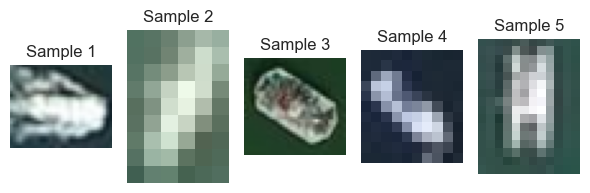

In [3]:
# Load the images from the directory
path = "E:/Datasets/MasatiV2/MasatiV2Boats"
image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))]

# Randomly select 5 images
random_samples = random.sample(image_files, 5)

# Display 5 random samples
plt.figure(figsize=(6, 3))
for i, file in enumerate(random_samples, 1):
    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i)
    plt.imshow(img_rgb)
    plt.title(f"Sample {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Visualize the size distribution

100%|██████████| 4054/4054 [00:23<00:00, 172.93it/s]


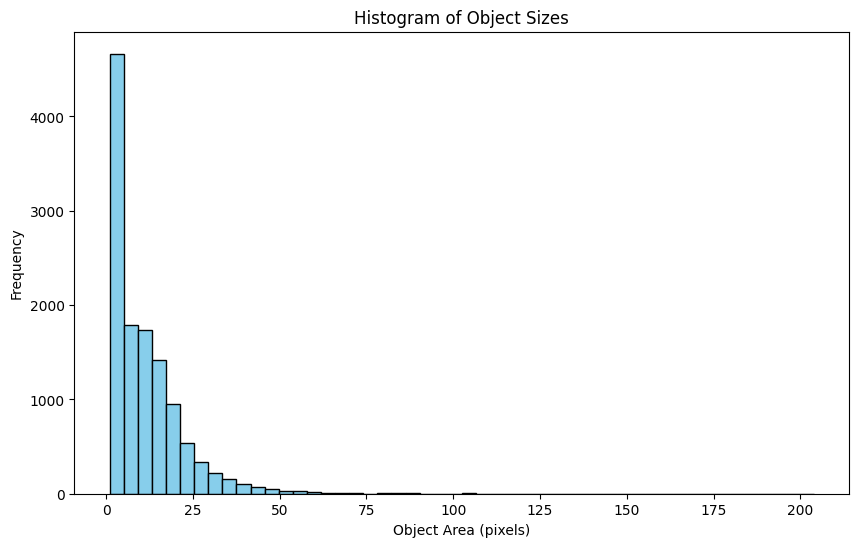

In [3]:
# To store object sizes for each image
object_sizes = []

# Loop through each image and calculate object sizes (area)
for file in tqdm(image_files):
    img_path = os.path.join(path, file)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    obj_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    object_sizes.append(obj_rgb.shape)

# Flatten all the areas into one list
all_object_sizes = [size for sublist in object_sizes for size in sublist]

# Create a histogram of object sizes
plt.figure(figsize=(10, 6))
plt.hist(all_object_sizes, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Object Sizes")
plt.xlabel("Object Area (pixels)")
plt.ylabel("Frequency")
plt.show()

## Resolution Heatmap

100%|██████████| 4054/4054 [00:00<00:00, 5819.80it/s]


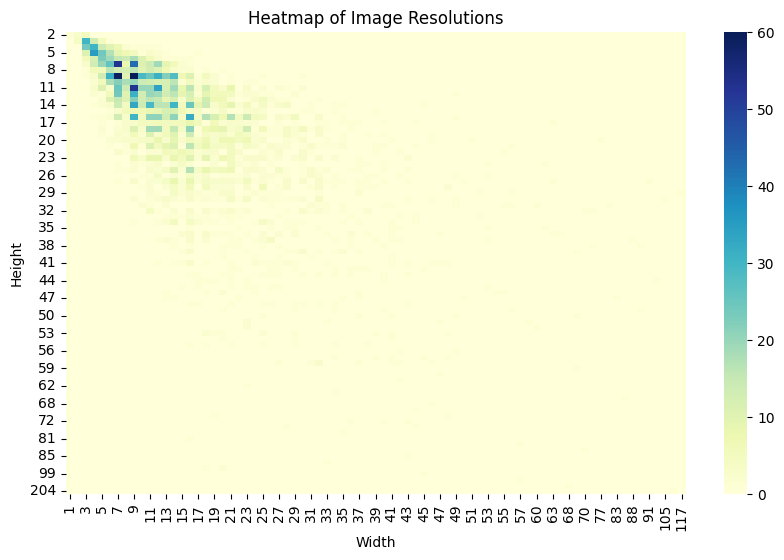

In [12]:
# Load images and get resolutions (height, width)
image_resolutions = []

for file in tqdm(image_files):
    img_path = os.path.join(path, file)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        continue

    height, width, _ = img.shape
    image_resolutions.append((height, width))

# Convert list of resolutions to a DataFrame to count occurrences of each resolution
resolution_counts = pd.DataFrame(image_resolutions, columns=["Height", "Width"])
resolution_frequency = resolution_counts.groupby(["Height", "Width"]).size().reset_index(name="Frequency")

# Pivot the DataFrame for the heatmap (resolutions as indices)
heatmap_data = resolution_frequency.pivot_table(index="Height", columns="Width", values="Frequency", fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt="d", cbar=True)
plt.title("Heatmap of Image Resolutions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

## Visualize Resize Operation:

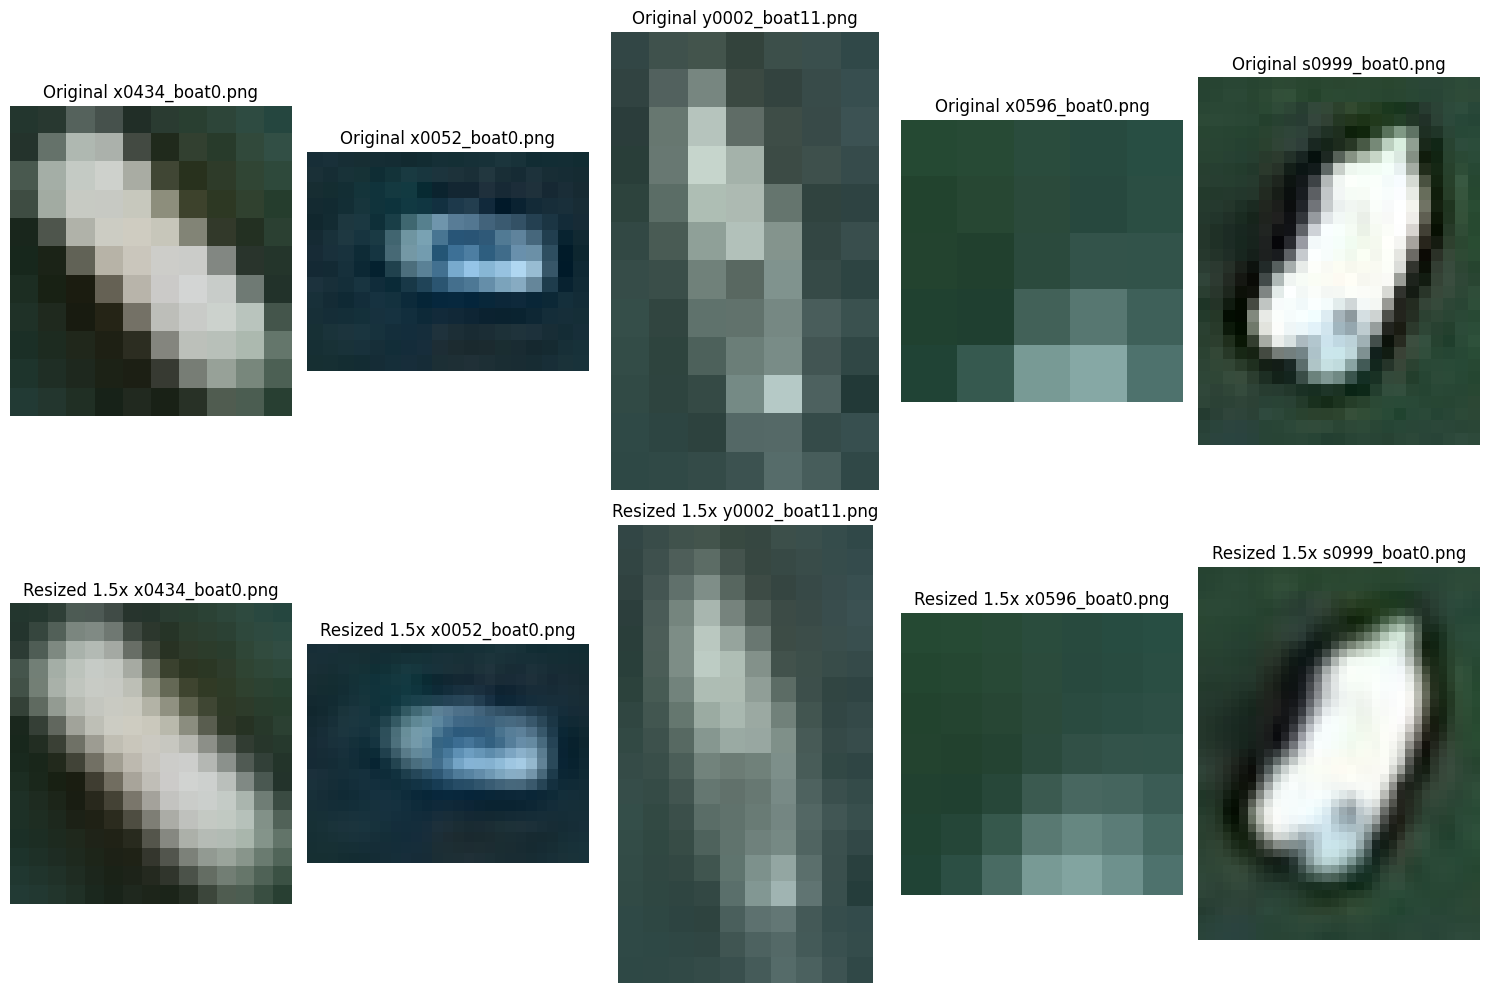

In [16]:
def visualize_resize_effect(path, sample_size=5, scale_factor=1.5):
    """
    Visualize the effect of resizing images by a specified scale factor.

    Args:
        path (str): The directory path containing the images.
        sample_size (int): Number of random images to sample and visualize.
        scale_factor (float): The factor by which to resize the images (1.5 for 50% increase).
    """
    # List all images in the directory
    image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))]

    # Randomly sample 5 images
    random_samples = random.sample(image_files, sample_size)

    plt.figure(figsize=(15, 10))

    # Loop through the sampled images and resize them
    for i, file in enumerate(random_samples, 1):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:
            continue

        # Resize the image by the scale factor
        height, width, _ = img.shape
        resized_img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))

        # Convert BGR to RGB for proper display in matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

        # Display the original and resized images side by side
        plt.subplot(2, sample_size, i)
        plt.imshow(img_rgb)
        plt.title(f"Original {file}")
        plt.axis('off')

        plt.subplot(2, sample_size, i + sample_size)
        plt.imshow(resized_rgb)
        plt.title(f"Resized 1.5x {file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_resize_effect(path, sample_size=5, scale_factor=1.5)

## Filter Objects

In [8]:
def count_images_in_size_range(path, min_width, max_width, min_height, max_height):
    """
    Calculate the number of images that would be saved after filtering based on input size.

    Args:
        path (str): The directory path containing the images.
        min_width (int): Minimum width of images to include.
        max_width (int): Maximum width of images to include.
        min_height (int): Minimum height of images to include.
        max_height (int): Maximum height of images to include.

    Returns:
        int: The number of images that meet the size criteria.
    """
    image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))]
    count = 0

    for file in image_files:
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:
            continue

        # Get image dimensions (height, width)
        height, width, _ = img.shape

        # Check if the image dimensions are within the specified range
        if min_width <= width <= max_width and min_height <= height <= max_height:
            count += 1

    return count

# Define the directory and size range
min_width = 12
max_width = 64
min_height = 12
max_height = 64

# Call the function to count images within the specified size range
num_images = count_images_in_size_range(path, min_width, max_width, min_height, max_height)

# Print the result
print(f"Number of images that match the size range: {num_images}")

Number of images that match the size range: 1887


## Remove Strange Objects

m0011_boat1.png: Rejected for small area (16.00).


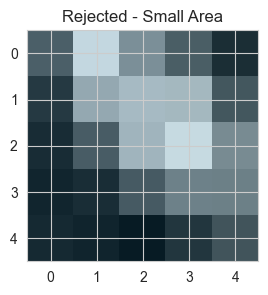

m0011_boat2.png: Rejected for small area (12.00).


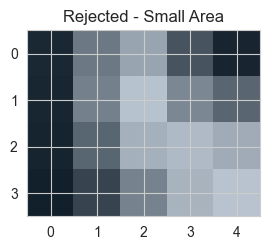

m0087_boat12.png: Rejected for small area (12.00).


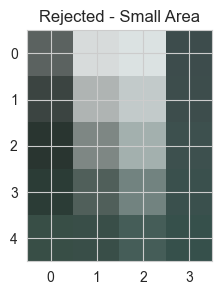

m0090_boat1.png: Rejected for small area (30.00).


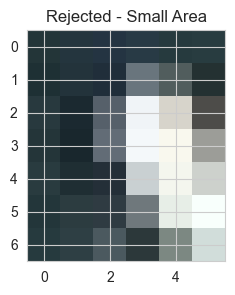

m0094_boat7.png: Rejected for small area (15.00).


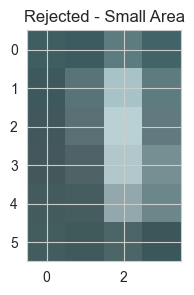

In [15]:
def inspect_rejected_images(
    input_folder,
    min_area=16,
    min_extent=0.3,
    min_solidity=0.5,
    show_reason=True
):

    count = 0
    for filename in os.listdir(input_folder):
        if count ==5:
            break

        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        path = os.path.join(input_folder, filename)
        image = cv2.imread(path)
        if image is None:
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            if show_reason:
                print(f"{filename}: No contours found.")
            plt.figure(figsize=(3, 3))
            plt.imshow(image, cmap='gray')
            plt.title("Rejected - No contours")
            plt.show()
            count += 1
            continue

        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        if area < min_area:
            if show_reason:
                print(f"{filename}: Rejected for small area ({area:.2f}).")
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(3, 3))
            plt.imshow(image_rgb)
            plt.title("Rejected - Small Area")
            plt.show()
            count += 1
            continue

        x, y, w, h = cv2.boundingRect(largest)

        bounding_box_area = w * h
        extent = area / float(bounding_box_area)
        hull = cv2.convexHull(largest)
        hull_area = cv2.contourArea(hull)
        solidity = area / float(hull_area) if hull_area != 0 else 0

        if extent < min_extent:
            if show_reason:
                print(f"{filename}: Rejected for extent ({extent:.2f}).")
            plt.figure(figsize=(3, 3))
            plt.imshow(image, cmap='gray')
            plt.title("Rejected - Low Extent")
            plt.show()
            count += 1
            continue

        if solidity < min_solidity:
            if show_reason:
                print(f"{filename}: Rejected for solidity ({solidity:.2f}).")
            cv2.drawContours(image, [hull], -1, (0, 255, 255), 2)
            plt.figure(figsize=(3, 3))
            plt.imshow(image, cmap='gray')
            plt.title("Rejected - Low Solidity")
            plt.show()
            count += 1
            continue

        # If it passed all filters, don't show
        continue

inspect_rejected_images(
    input_folder=path,
    min_area=32,
    min_extent=0.4,
    min_solidity=0.6
)
